<a href="https://colab.research.google.com/github/cboyda/MachineLearning/blob/main/PA3_Team1_W23_ipynd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PA3: k-NN**

Team member names:

*  Brett Adams
*  Cailenys Leslie
*  Clinton Boyda
*  Tanvir Hossain
*  Ram Dershan

Dataset: 
[New York City Airbnb Open Data](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

In [4]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from  sklearn import neighbors
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [5]:
# Connect to Dataset

filename = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/AB_NYC_2019.csv"

df = pd.read_csv(filename)

# we can work on merging the new dataset in the code below = Brett?

# **Feature Scaling**


In [6]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [7]:
# drop all columns not necessary
# over simplifying for our first iteration

df.drop(['neighbourhood','name','host_name','number_of_reviews','last_review','reviews_per_month','calculated_host_listings_count','id','host_id','latitude','longitude'], axis=1, inplace = True)
# df.drop('a', inplace=True, axis=1)

In [8]:
numeric_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(exclude=[np.number])


In [9]:
#define clean as duplicate
df_clean = df.copy()

### 1. Check extreme values:

a. Define what an extreme value is for each feature, e.g., using boxplots.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


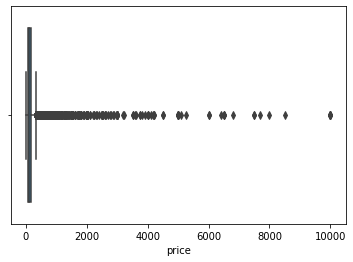

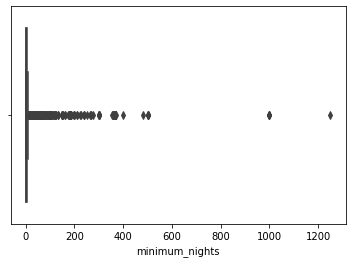

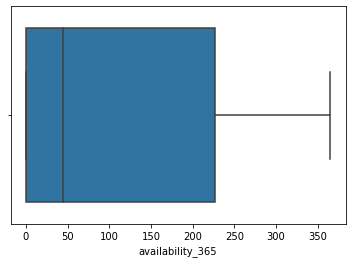

In [10]:
# create boxplots
for column in numeric_data.columns:
    plt.figure()            
    sns.boxplot(numeric_data[column])

In [11]:
# let's try looking at the histograms so the box plots are easier to read
for column in numeric_data.columns:
  fig = px.histogram(df, x=column, marginal="box")
  fig.show()

In [12]:
extreme_values = []

In [13]:
for column in numeric_data.columns:
  # Select the first quantile
  q1 = df[column].quantile(0.25)

  # Select the third quantile
  q3 = df[column].quantile(0.75)

  max = df[column].quantile(1)

  # Create a mask inbetween q1 & q3
  IQR = q3 - q1

  # Filtering the initial dataframe with a mask
  #filtered = df.query('(@q1 - 1.5 * @IQR) <= [column] <= (@q3 + 1.5 * @IQR)')
  # Filtering Values between Q1-1.5IQR and Q3+1.5IQR  

  #maximum outliers
  bottom_fence = 0 if (q1 - 1.5 * IQR) < 0 else q1 - 1.5 * IQR
  upper_fence = max if (q3 + 1.5 * IQR) > max else (q3 + 1.5 * IQR)
  #display(column, bottom_fence, upper_fence)
  extreme_values.append([column, bottom_fence, upper_fence])


In [14]:
extreme_values

[['price', 0, 334.0],
 ['minimum_nights', 0, 11.0],
 ['availability_365', 0, 365.0]]

In [15]:
df.describe(include=['int64' , 'float64']).loc[['std','min','max','75%']]

,price,minimum_nights,availability_365
std,240.15417,20.51055,131.622289
min,0.00000,1.00000,0.000000
max,10000.00000,1250.00000,365.000000
75%,175.00000,5.00000,227.000000


In [16]:
df.describe()


,price,minimum_nights,availability_365
count,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,112.781327
std,240.154170,20.510550,131.622289
min,0.000000,1.000000,0.000000
25%,69.000000,1.000000,0.000000
50%,106.000000,3.000000,45.000000
75%,175.000000,5.000000,227.000000
max,10000.000000,1250.000000,365.000000


In [17]:
# how many rows in our entire data?
df.shape

(48895, 5)

In [18]:
df.dtypes

neighbourhood_group    object
room_type              object
price                   int64
minimum_nights          int64
availability_365        int64
dtype: object

b. Do any of your features contain extreme values? List the features & the number of extreme values for each feature.


In [52]:
# confirm standard deviation for price is too large = needs to drop extreme values
df.describe(include='all').loc['std']

neighbourhood_group           NaN
room_type                     NaN
price                   240.15417
minimum_nights           20.51055
availability_365       131.622289
Name: std, dtype: object

In [20]:
# how many rows our price column?
df.price.count()

48895

In [21]:
# lookup in extreme_values UPPER/LOWER FENCE values
def get_upperfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][2]
    else:
      continue

def get_lowerfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][1]
    else:
      continue


In [22]:
# looking at price specifically 75% is 175 but max is 10,000 so
# what is a good 'extreme' value? boxplot shows this as 374
df.loc[df.price > get_upperfence('price'), 'price'].count()

2972

In [23]:
# list of all rows that show price > extreme
df.loc[df.price > get_upperfence('price')]

,neighbourhood_group,room_type,price,minimum_nights,availability_365
61,Manhattan,Entire home/apt,375,180,180
85,Brooklyn,Entire home/apt,800,1,7
103,Manhattan,Entire home/apt,500,4,243
114,Manhattan,Entire home/apt,350,2,298
121,Brooklyn,Entire home/apt,400,2,216
...,...,...,...,...,...
48758,Queens,Entire home/apt,350,2,364
48833,Manhattan,Entire home/apt,475,2,64
48839,Brooklyn,Private room,800,1,23
48842,Manhattan,Entire home/apt,350,1,9


feature = availability_365 shows an extreme value for the value zero, and this really means that unit isn't available so best we just drop those indices to ensure we are only looking at available units!


In [24]:
df.loc[df.availability_365 == 0, 'availability_365'].count()

17533

In [25]:
df[df.availability_365 == 0]

,neighbourhood_group,room_type,price,minimum_nights,availability_365
4,Manhattan,Entire home/apt,80,10,0
6,Brooklyn,Private room,60,45,0
8,Manhattan,Private room,79,2,0
14,Manhattan,Entire home/apt,120,90,0
20,Brooklyn,Entire home/apt,299,3,0
...,...,...,...,...,...
48550,Queens,Private room,45,1,0
48731,Brooklyn,Entire home/apt,111,8,0
48756,Manhattan,Entire home/apt,129,2,0
48760,Queens,Private room,46,1,0


In [26]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Availability_365 percentage over extreme:')
(df.loc[df.availability_365 == 0, 'availability_365'].count() / df.availability_365.count()) * 100 

'Availability_365 percentage over extreme:'

35.858472236424994

Normally dropping 36% of the values would NOT be considered a good solution, but we assuming availability_365 is a range from 0 to 365.  If a unit is 0, this means the owner did not put it for rent for ANY days that year.  So why even offer that as a solution to a potential renter?  We interpret this to mean that 36% of inventory (rooms to rent) were simply not available during this period and that is not part of the business problem we are trying to solve nor analyze.

In [27]:
# dropping availability_365 feature at this stage since it was a filter not a feature
# df_clean.drop(['availability_365'], axis=1, inplace = True)

In [28]:
df_clean.shape

(48895, 5)

c. Do the number of extreme values make-up a substantial portion of that feature? (e.g. 5%) Or are they so few that you could consider dropping those samples? Explain.


In [29]:
df.loc[df.price > get_upperfence('price'), 'price'].count()

2972

In [30]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Pricing percentage over extreme:')
(df.loc[df.price > get_upperfence('price'), 'price'].count() / df.price.count()) * 100 

'Pricing percentage over extreme:'

6.078331117701197

Create new df_clean set with the extreme pricing values removed.

In [31]:
df_clean.drop(df_clean[df_clean['price'] > get_upperfence('price')].index, inplace = True)

In [32]:
df_clean.shape

(45923, 5)

In [33]:
# group the prices into categories
# view price
# log price
# break price into 3 groups based on ?? == 
# neighbour_groups becomes the colour background of the heat map
# (dots in the heatmap are the 5 neighbour_groups)

In [34]:
fig = px.histogram(df_clean, df_clean['price'], marginal="box")
fig.show()

Price needs log to get gaussian graph.

In [35]:
# log of zero fails so we count how many have zero, if small, then drop
df_clean.loc[df_clean.price  == 0, 'price'].count()

11

In [36]:
zero_price = df_clean.loc[df_clean.price  == 0, 'price'].index

In [37]:
# zero price rows is low, dropping
df_clean.drop(zero_price,axis=0,inplace=True)

In [38]:
# add log of price to dataframe
df_clean['log_price'] = np.log(df_clean['price'])

In [39]:
fig = px.histogram(df_clean, (df_clean['log_price']), marginal="box")
fig.show()

In [40]:
# break apart price groups by <q1, q1>median, median>q3, q3>
#price_q1 = df_clean['log_price'].quantile(0.25)
#price_mean = df_clean['log_price'].quantile(0.5)
#price_q3 = df_clean['log_price'].quantile(0.75)



In [41]:
# create new price_group text = "budget" or "average" or "high" or "luxury"
# df_clean["price_group"] = 'budget' if df_clean['log_price'] < price_q1 else 'average' if df_clean['log_price'] < price_median else 'high' if df_clean['log_price'] < price_q3 else 'luxury'


In [42]:
df_clean.columns

Index(['neighbourhood_group', 'room_type', 'price', 'minimum_nights',
       'availability_365', 'log_price'],
      dtype='object')

### 2. Min-max scale your data and store this in a variable name that indicates that you’ve min-max scaled the data, e.g., X_train_minmax.

In [50]:
# Normalization

feature1 = df_clean["log_price"]
feature2 = df_clean["minimum_nights"]
feature3 = df_clean["availability_365"]

import sklearn.preprocessing
feature1_STD = feature1.std()
feature2_STD = feature2.std()
feature3_STD = feature3.std()

## create array of each features for processing
feature1_process = df_clean[["log_price"]].values
feature2_process= df_clean[["minimum_nights"]].values
feature3_process = df_clean[["availability_365"]].values

## create standardize and minmax object for each feature
feature1_mm = sklearn.preprocessing.MinMaxScaler()
feature1_mm_scaled = feature1_mm.fit_transform(feature1_process)
feature1_mm_scaled_STD = feature1_mm_scaled.std()

## create standardize and minmax object for each feature
feature2_mm = sklearn.preprocessing.MinMaxScaler()
feature2_mm_scaled = feature1_mm.fit_transform(feature2_process)
feature2_mm_scaled_STD = feature2_mm_scaled.std()

## create standardize and minmax object for each feature
feature3_mm = sklearn.preprocessing.MinMaxScaler()
feature3_mm_scaled = feature3_mm.fit_transform(feature3_process)
feature3_mm_scaled_STD = feature3_mm_scaled.std()

In [44]:
print('feature1 std = ', feature1_STD, 'feature1 mm std = ', feature1_mm_scaled_STD)
print('feature2 std = ', feature2_STD, 'feature2 mm std = ', feature2_mm_scaled_STD)
print('feature3 std = ', feature3_STD, 'feature3 mm std = ', feature3_mm_scaled_STD)

feature1 std =  0.5788558437108734 feature1 mm std =  0.16498227652815584
feature2 std =  19.859504858170265 feature2 mm std =  0.015900150984035424
feature3 std =  130.28436781024052 feature3 mm std =  0.35693958617469174


### 3. Standardize your data and store this in a variable name that indicates that you’ve standardized the data, e.g., X_train_standard.


In [51]:
# Standard Scalering

#feature 1
feature1_scaler = sklearn.preprocessing.StandardScaler()
feature1_scaled = feature1_scaler.fit_transform(feature1_process)
feature1_scaled_STD = feature1_scaled.std()

#feature 2
feature2_scaler = sklearn.preprocessing.StandardScaler()
feature2_scaled = feature1_scaler.fit_transform(feature2_process)
feature2_scaled_STD = feature2_scaled.std()

#feature 3
feature3_scaler = sklearn.preprocessing.StandardScaler()
feature3_scaled = feature3_scaler.fit_transform(feature3_process)
feature3_scaled_STD = feature3_scaled.std()



In [46]:
print('feature1 std = ', feature1_STD, 'feature1 standardize std = ', feature1_scaled_STD, 'feature1 mm std = ', feature1_mm_scaled_STD)
print('feature2 std = ', feature2_STD, 'feature2 standardize std = ', feature2_scaled_STD, 'feature2 mm std = ', feature2_mm_scaled_STD)
print('feature3 std = ', feature3_STD, 'feature1 standardize std = ', feature3_scaled_STD,'feature3 mm std = ', feature3_mm_scaled_STD)

feature1 std =  0.5788558437108734 feature1 standardize std =  1.0 feature1 mm std =  0.16498227652815584
feature2 std =  19.859504858170265 feature2 standardize std =  1.0 feature2 mm std =  0.015900150984035424
feature3 std =  130.28436781024052 feature1 standardize std =  1.0 feature3 mm std =  0.35693958617469174


### 4. Visual & numeric comparison 1: Choose 3 features, and compare their standard deviations of after standardizing & min-max scaling. What is the difference between these two approaches on how your features are distributed [Hint: look at the mean].


**Visual comparason**

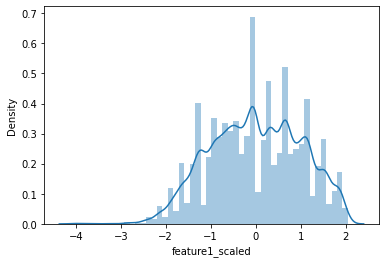

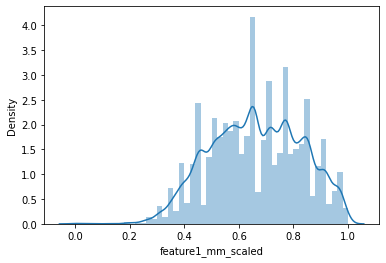

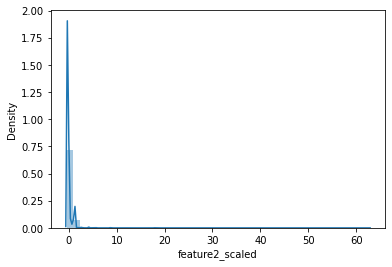

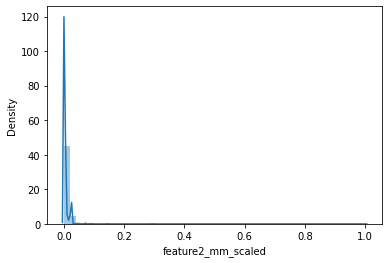

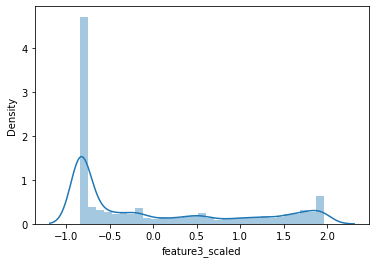

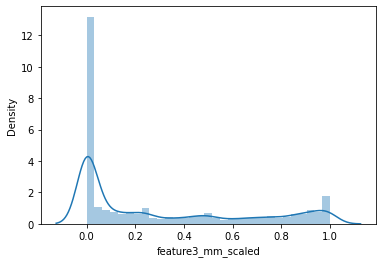

In [48]:
all_features_df = pd.DataFrame({'feature1_scaled':feature1_scaled[:,0], 'feature1_mm_scaled':feature1_mm_scaled[:,0],'feature2_scaled':feature2_scaled[:,0], 'feature2_mm_scaled':feature2_mm_scaled[:,0],'feature3_scaled':feature3_scaled[:,0], 'feature3_mm_scaled':feature3_mm_scaled[:,0]})

import warnings
warnings.filterwarnings("ignore")
for i, column in enumerate(all_features_df.columns, 1):
    sns.distplot(all_features_df[column])
    plt.show()

**Observation:**

From the above graphs, we can notice that in general applying Max-Min Nomaralization in our dataset has generated smaller standard deviations than using Standardisation method. This implies the data are more concentrated around the mean if we scale data using Max-Min Nomaralization.

**Numeric comparison**

In [49]:
all_features_df = pd.DataFrame({'feature1_scaled':feature1_scaled[:,0], 'feature1_mm_scaled':feature1_mm_scaled[:,0],'feature2_scaled':feature2_scaled[:,0], 'feature2_mm_scaled':feature2_mm_scaled[:,0],'feature3_scaled':feature3_scaled[:,0], 'feature3_mm_scaled':feature3_mm_scaled[:,0]})
all_features_df 

,feature1_scaled,feature1_mm_scaled,feature2_scaled,feature2_mm_scaled,feature3_scaled,feature3_mm_scaled
0,0.652389,0.769935,-0.299002,0.000000,1.962068,1.000000
1,1.364412,0.887406,-0.299002,0.000000,1.885312,0.972603
2,0.663945,0.771842,-0.198294,0.001601,1.962068,1.000000
3,-0.237842,0.623063,-0.299002,0.000000,0.649541,0.531507
4,-0.422017,0.592677,0.154186,0.007206,-0.839526,0.000000
...,...,...,...,...,...,...
45907,-0.652702,0.554619,-0.248648,0.000801,-0.770446,0.024658
45908,-1.619474,0.395118,-0.147939,0.002402,-0.563204,0.098630
45909,0.204925,0.696112,0.154186,0.007206,-0.632285,0.073973
45910,-1.069325,0.485883,-0.299002,0.000000,-0.824175,0.005479


**Observation:**

We confirmed in contrast to standardisation, we obtained smaller standard deviations through the process of Max-Min Normalization, except for few values in feature 3 (availability_365)




### 5. Visual & numeric comparison 2: Generate a boxplot for all three datasets, the original, the  min-max scaled, and the standardized dataset. We expect to see a comparison like the one in lab, where each box-n-whiskers plot corresponds to a different feature.


In [ ]:
df_clean.count()

neighbourhood_group    45912
room_type              45912
price                  45912
minimum_nights         45912
availability_365       45912
log_price              45912
dtype: int64

In [ ]:
# test for clean enough data to run k-NN
# zeros denote no nulls
df_clean.isna().sum()

neighbourhood_group    0
room_type              0
price                  0
minimum_nights         0
availability_365       0
log_price              0
dtype: int64

In [ ]:
df_clean['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [ ]:
df_clean.drop(['price'], axis=1, inplace = True)
df_clean

,neighbourhood_group,room_type,minimum_nights,availability_365,log_price
0,Brooklyn,Private room,1,365,5.003946
1,Manhattan,Entire home/apt,1,355,5.416100
2,Manhattan,Private room,3,365,5.010635
3,Brooklyn,Entire home/apt,1,194,4.488636
4,Manhattan,Entire home/apt,10,0,4.382027
...,...,...,...,...,...
48890,Brooklyn,Private room,2,9,4.248495
48891,Brooklyn,Private room,4,36,3.688879
48892,Manhattan,Entire home/apt,10,27,4.744932
48893,Manhattan,Shared room,1,2,4.007333


In [ ]:
column_names= df_clean.columns
features = column_names[1:]
label = column_names[0]
display(features, label)

Index(['room_type', 'minimum_nights', 'availability_365', 'log_price'], dtype='object')

'neighbourhood_group'

In [ ]:
features

Index(['room_type', 'minimum_nights', 'availability_365', 'log_price'], dtype='object')

# **Exploring k-NN construction:**

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [ ]:
X_preprocess = make_column_transformer((OrdinalEncoder(), features), remainder='passthrough')
y_preprocess = LabelEncoder()

In [ ]:

y = y_preprocess.fit_transform(df_clean[label])
y

array([1, 2, 2, ..., 2, 2, 2])

In [ ]:
X = X_preprocess.fit_transform(df_clean[features])
X

array([[  1.,   0., 365., 137.],
       [  0.,   0., 355., 213.],
       [  1.,   2., 365., 138.],
       ...,
       [  0.,   9.,  27., 103.],
       [  2.,   0.,   2.,  43.],
       [  1.,   6.,  23.,  78.]])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 1. Vary the n_neighbors parameter:

a. Create a k-NN classifier model querying 5 neighbors.

In [ ]:
knn_1a = KNeighborsClassifier(n_neighbors=5)
knn_1a.fit(X_train, y_train)

KNeighborsClassifier()

b. Create a k-NN classifier model querying 11 neighbors.

In [ ]:
knn_1b = KNeighborsClassifier(n_neighbors=11)
knn_1b.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

c. Create a k-NN classifier model querying 15 neighbors.

In [ ]:
knn_1c = KNeighborsClassifier(n_neighbors=15)
knn_1c.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

###2. Vary the weights parameter:

a. Create a k-NN classifier model with weights parameter set to “uniform”.

In [ ]:
knn_2a = KNeighborsClassifier(weights = "uniform")
knn_2a.fit(X_train, y_train)

KNeighborsClassifier()

b. Create a k-NN classifier model with weights parameter set to “distance”.

In [ ]:
knn_2b = KNeighborsClassifier(weights = "distance")
knn_2b.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

# **k-NN evaluation:**

### 3. Plot the decision boundaries for each class for the different n_neighbors and weights.


In [ ]:
# from https://stackoverflow.com/questions/72246343/importerror-cannot-import-name-decisionboundarydisplay-from-sklearn-inspecti
# pip install -U scikit-learn --user

In [ ]:
features

Index(['room_type', 'minimum_nights', 'availability_365', 'log_price'], dtype='object')

In [ ]:
#heatmap_features= (['room_type','log_price'])

In [ ]:
# from https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.colors import ListedColormap
# from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

n_neighbors = 5

# import some data to play with
# iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
# X and y already defined
# X = iris.data[:, :2]
# y = iris.target
X = X[:,:2]

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue", "red"])
cmap_bold = ["darkorange", "c", "darkblue", "gray"]

for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=features[0],
        ylabel=features[1],
        shading="auto",
    )

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )

plt.show()

ImportError: ignored

In [ ]:
# from https://towardsdatascience.com/machine-learning-basics-k-nearest-neighbors-classification-6c1e0b209542

from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, knn_1a.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green','orange','yellow'))(i), label = j)
plt.title('KNN Classification')
plt.xlabel('DMV_Test_1')
plt.ylabel('DMV_Test_2')
plt.legend()
plt.show()

ValueError: ignored

### 4. Use the sklearn.metrics.accuracy_score method to compare the accuracy of the several values of k, k=5, 11, and 15, and compare your original and your normalized (min-max scaled and standardized) datasets.


### 5. Test the performance of each k-NN classifier using other evaluation metrics (precision, recall and F1 scores) and see if there is any difference if you chose different metrics.


### 6. Imagine that you have another classifier that always predicts the most common label, do a baseline comparison for your ML models.


### 7. Generate a simple plot of the test and training learning curve for each k-NN and check if you have a low/high bias or low/high variance learning. We can use the function learning_curve to generate the values that are required to plot such a learning curve (number of samples that have been used, the average scores on the training sets and the average scores on the validation sets):
